# 32x32 expGP image reconstruction

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [3]:
Npix = 32
N = Npix**2

l = torch.arange(Npix)
L1, L2 = torch.meshgrid(l, l)
L = torch.stack([L1, L2], dim = -1)
T = L.unsqueeze(0).unsqueeze(0) - L.unsqueeze(2).unsqueeze(2)
T = (T**2).sum(-1)**0.5
T = T.view(N, N)
Cov = torch.exp(-T/64)*0.5 + torch.exp(-T/32)*.25 + torch.exp(-T/16)*.125

dist = torch.distributions.MultivariateNormal(torch.zeros(N), Cov)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


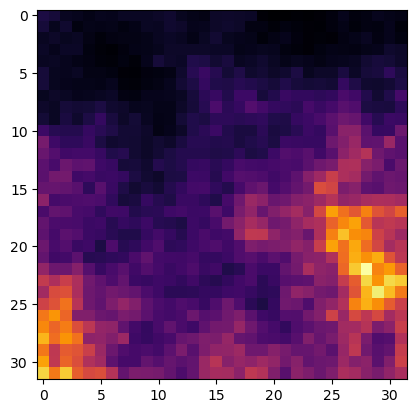

In [6]:
def sample_GP(N, gamma = 3):
    #z = np.random.multivariate_normal(np.zeros(N), Cov.numpy()).reshape(Npix, Npix)
    z = dist.sample(torch.Size([1]))[0].numpy().reshape(Npix, Npix)
    return z

z = sample_GP(N, gamma = 2.5)
plt.imshow(np.exp(z), cmap='inferno')

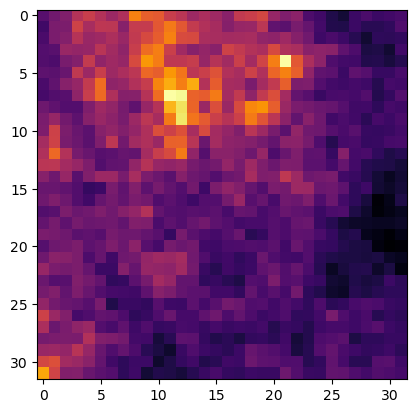

In [10]:
class Sim(swyft.Simulator):
    def __init__(self, sigma = .1, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = sigma    
        self.bounds = bounds
        
    def sample_GP(self):
        if self.bounds is None:
            return sample_GP(N, gamma = 2.5)
        else:
            i = np.random.randint(len(self.bounds))
            return self.bounds[i]
            
  
    def build(self, graph):
        z = graph.node("z", lambda: self.sample_GP())
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(Npix, Npix)*self.sigma, y)
        
        
sim = Sim()
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')

In [11]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu")
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, A, B):
        x = A["x"].view(-1, N)
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
        result = self.lre(f, A['z'].view(-1,N), B['z'].view(-1, N))
        return result

In [12]:
samples = sim.sample(10000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 256)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
net = Network(D=N)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
net.lre._momentum = 0.01

In [15]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 20)
trainer.fit(net, dm)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /gpfs/home2/weniger/swyft/notebooks/lightning_logs/version_2617613/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/utiliti

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (36) is smaller tha

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


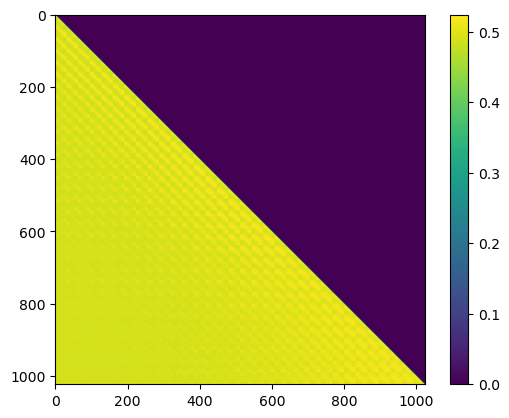

In [16]:
Phi = net.lre.Phi.detach().cpu().numpy()
plt.imshow(Phi)
plt.colorbar()

In [17]:
i = np.random.randint(len(samples))
print(i)
sample0 = samples[i]

4973


/tmp/ipykernel_2048668/860563151.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()


tensor(9.9868, device='cuda:0', dtype=torch.float64)


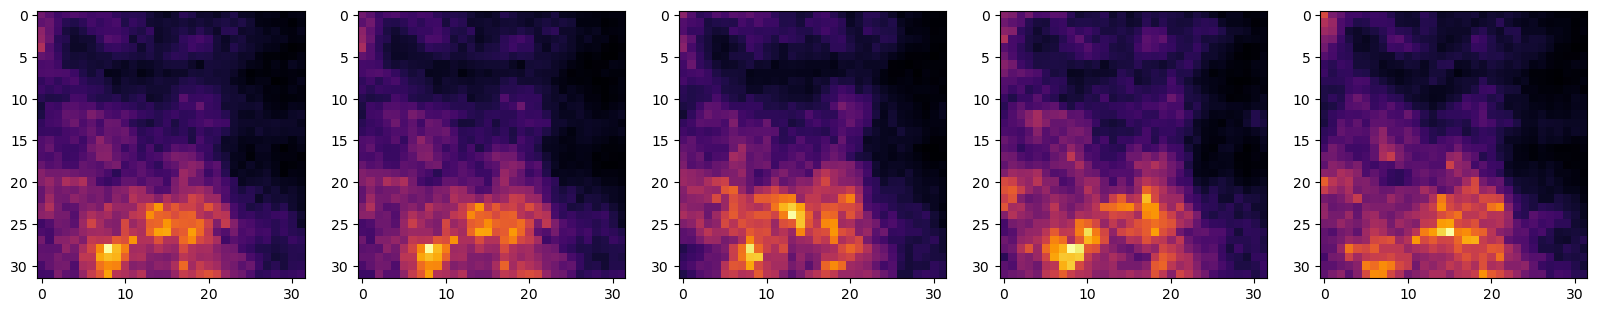

In [20]:
Cov = Cov.double().cuda()
x = torch.tensor(sample0['x']).view(-1, N)
y = torch.tensor(sample0['y']).view(-1, N)
net.cuda()
f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()

#print(f.shape)

draws = net.lre.get_samples(10000, f, cov = Cov*1, gamma = .1).view(-1, Npix, Npix).cpu()

plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)
plt.imshow(x.view(Npix,Npix), cmap='inferno')
plt.subplot(1,5,2)
plt.imshow(y.view(Npix,Npix), cmap='inferno')
for i in range(3):
    plt.subplot(1, 5, i+3)
    plt.imshow(np.exp(draws[i]), cmap='inferno')

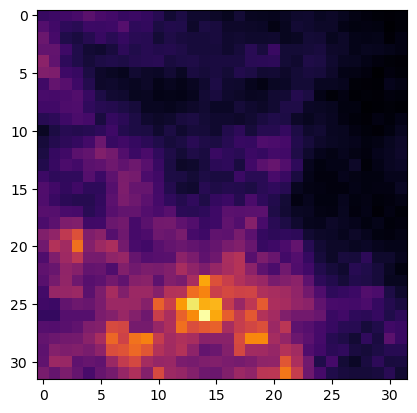

In [21]:
sim = Sim(bounds = draws)
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')